#### These codes were generated with the help of ChatGPT

### Enhancing Sky View Factor (SVF) images
QGIS ans raster calculator does not perform this well.
In here I have downscaled the image size with the cv2, because I had memory issues with my computer with performing. 
QGIS does not have cv2.equalizeHist() wich is not histogram equalization. It improves the the interpretability of the SVF image. 
rasterio helps in reading and writing with larger image files. 

int8 creating histogram 0-255, while using 0 as nodata value the results in histogram are 1-255.
The later one after this is made with float32 and nodata value -9999.
The histogram is in file ../01_Data/03_Figures/svf_hist_eq.tif

From a svf histogram the natural, fluvial stream beds can be clearly seen. The stream may get cutted or broken because of a farmed field, but the still can be seen shadows of the original situation in the histogram.

In [3]:
import rasterio
import cv2
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

## Creating the SVF histogram
Creating the Sky View factor histogram.

In [12]:
def process_image(layer_path, output_path):
    # Open the raster file with rasterio
    with rasterio.open(layer_path) as src:
        # Read the image data
        svf_image = src.read(1)  # Read the first band

        print(f"Original image size: {svf_image.shape[1]}x{svf_image.shape[0]} pixels")

        # Normalize the image to 0-255 and convert to 8-bit
        svf_image_normalized = cv2.normalize(svf_image, None, 0, 255, cv2.NORM_MINMAX)
        svf_image_8bit = np.uint8(svf_image_normalized)

        #Downscale the image by a factor (e.g., 0.5 for half size) ##this may be needed if you have problems with memory usage
        downscale_factor = 1
        width = int(svf_image_8bit.shape[1] * downscale_factor)
        height = int(svf_image_8bit.shape[0] * downscale_factor)
        svf_image_small = cv2.resize(svf_image_8bit, (width, height), interpolation=cv2.INTER_AREA)

        #svf_image_small = svf_image_8bit  # Use the original image without resizing

        print(f"Resized image size: {svf_image_small.shape[1]}x{svf_image_small.shape[0]} pixels")

        # Apply Histogram Equalization using OpenCV
        svf_hist_eq = cv2.equalizeHist(svf_image_small)

        # Save the processed image using rasterio
        profile = src.profile
        profile.update(
            dtype=rasterio.uint8,
            count=1,
            width=width,
            height=height,
            compress='lzw',
            nodata=0 #use this if you get an error from the missinf nodata value
        )

        # Ensure the output directory exists
        output_dir = os.path.dirname(output_path)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(svf_hist_eq, 1)

        print(f"Processed image saved to {output_path}")

def main():
    layer_path = "E:/Gradu/SkyViewFactor/SkyViewFactor_10m_smoothen.tif" #first was 5m, this is 10m
    output_path = "E:/Gradu/SkyViewFactor_enhance/histogram/SVF_10m_smoothen.tif" 
    process_image(layer_path, output_path)

if __name__ == "__main__":
    main()

Original image size: 35997x47997 pixels
Resized image size: 35997x47997 pixels
Processed image saved to E:/Gradu/SkyViewFactor_enhance/histogram/SVF_10m_smoothen.tif


### Smoothing test with gaussian
First, and later, you can preview images with this code.

In here the results are not so good.

Data range: 0.716679573059082 to 1.0
Adjusted low threshold: 0.9878113865852356


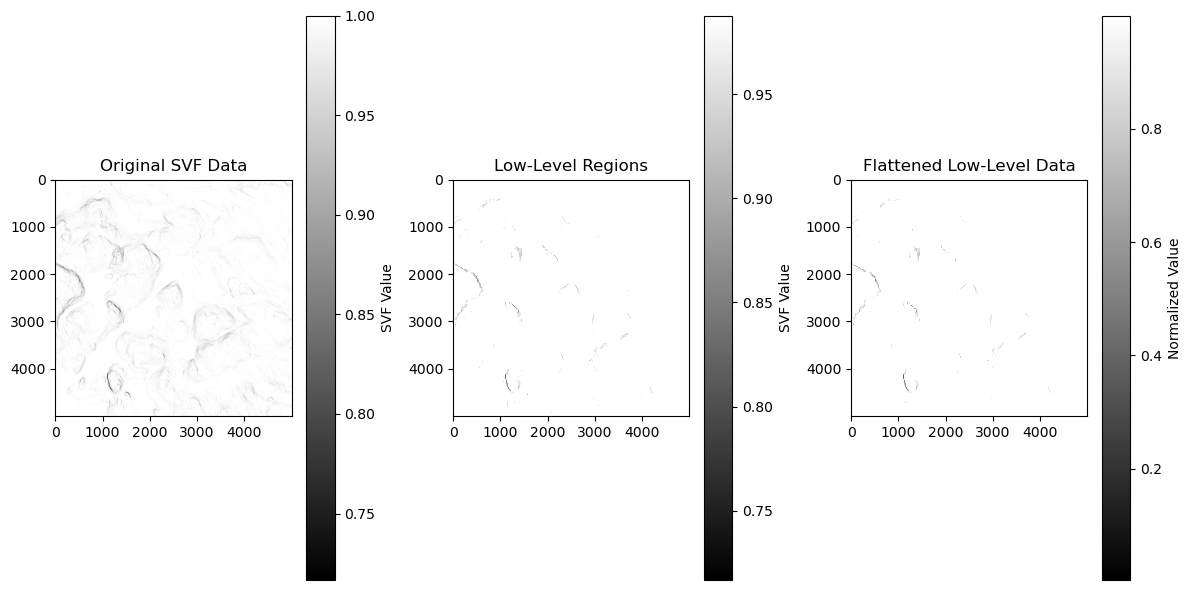

In [18]:
# Load the SVF image
file_path = "../../01_Data/01_Raw/features/features/SVF_11.npy"  # Example file
svf_data = np.load(file_path)

#Handle no-data values (-99999) if needed, depends on your datatype
svf_data[svf_data == -99999] = np.nan

# Check data range and adjust threshold if needed
data_min, data_max = np.nanmin(svf_data), np.nanmax(svf_data)
print(f"Data range: {data_min} to {data_max}")

# Define a threshold to identify "low" areas (adjust dynamically if needed)
low_threshold = 0.005  # Example static threshold
if low_threshold < data_min or low_threshold > data_max:
    low_threshold = np.percentile(svf_data[~np.isnan(svf_data)], 10)  # Adjust threshold
    print(f"Adjusted low threshold: {low_threshold}")

# Mask Elevated Values
low_mask = svf_data <= low_threshold

# Check mask validity
if np.sum(~np.isnan(low_mask)) == 0:
    print("No valid data found in the low-mask region.")
else:
    # Apply the mask to keep only low-level regions
    low_data = np.where(low_mask, svf_data, np.nan)

    # Flatten the Data
    min_value = np.nanmin(low_data)
    flattened_data = low_data - min_value

    # Normalize if needed
    normalized_data = flattened_data / np.nanmax(flattened_data)

    # Smooth the Data
    smoothed_data = gaussian_filter(normalized_data, sigma=0.5)

# Plotting Results
plt.figure(figsize=(12, 6))  # Adjusting the figure size to fit all three plots properly

# Original Data
plt.subplot(1, 3, 1)
plt.imshow(svf_data, cmap='gray', aspect='equal')  # Setting aspect to 'equal' for square view
plt.title("Original SVF Data")
plt.colorbar(label="SVF Value")

# Masked Low Data
plt.subplot(1, 3, 2)
plt.imshow(low_data, cmap='gray', aspect='equal')  # Setting aspect to 'equal' for square view
plt.title("Low-Level Regions")
plt.colorbar(label="SVF Value")

# Smoothed and Flattened Data
plt.subplot(1, 3, 3)
plt.imshow(smoothed_data, cmap='gray', aspect='equal')  # Setting aspect to 'equal' for square view
plt.title("Flattened Low-Level Data")
plt.colorbar(label="Normalized Value")

plt.tight_layout()
plt.show()


#### float32 and nodata -9999 test - skip this

In [6]:
import rasterio
import os
import numpy as np

In [10]:
def process_image(layer_path, output_path):
    # Open the input file
    with rasterio.open(layer_path) as src:
        svf = src.read(1)  # Read the first band
        
        # Define the profile while the dataset is still open
        profile = src.profile
        
    # Apply histogram equalization or other processing (example)
    # Normalize the data to [0, 1] range
    svf_hist_eq = np.interp(svf, (svf.min(), svf.max()), (0, 1)).astype(np.float32)

    # Set nodata value in the result
    svf_hist_eq[svf == -9999] = -9999  # Maintain -9999 as nodata

    # Create the output directory if it doesn't exist
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Update the profile for the output file, using float32 data type
    profile.update(
        dtype=rasterio.float32,  # Use float32 data type to support -9999 nodata value
        nodata=-9999,            # Set nodata value to -9999
        BIGTIFF='YES'            # Enable BigTIFF to support large files
    )

    # Write the output image
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(svf_hist_eq, 1)  # Write data as float32

    print(f"Processed image saved to {output_path}")

if __name__ == "__main__":
    layer_path = "E:/Gradu/SkyViewFactor/SkyViewFactor_10m_smoothen.tif"  # Input file path
    output_path = "E:/Gradu/SkyViewFactor_enhance/histogram/SVF_10m_smoothen2nodat_9999.tif"  # Output file path
    process_image(layer_path, output_path)

Processed image saved to E:/Gradu/SkyViewFactor_enhance/histogram/SVF_10m_smoothen2nodat_9999.tif


### This code slices the study area to smaller ones and then combines the histogram img

Better code below.

This code creates smaller image, test I made on my own computer but does not work well in QGIS. Result is fine, but the size is wrong. 

The histogram images are very informative though. It highlights the natural streams, ditches and the forest machine tire marks for example.

In [4]:
def process_image_in_chunks(layer_path, output_path, chunk_size=1000):
    with rasterio.open(layer_path) as src:
        profile = src.profile

        # Create the output file
        with rasterio.open(output_path, 'w', **profile) as dst:
            for i in range(0, src.height, chunk_size):
                for j in range(0, src.width, chunk_size):
                    # Read a chunk of the image
                    window = rasterio.windows.Window(j, i, min(chunk_size, src.width - j), min(chunk_size, src.height - i))
                    svf_chunk = src.read(1, window=window)

                    # Normalize the chunk
                    svf_chunk_normalized = cv2.normalize(svf_chunk, None, 0, 255, cv2.NORM_MINMAX)
                    svf_chunk_8bit = np.uint8(svf_chunk_normalized)

                    # Downscale the chunk
                    downscale_factor = 0.5
                    chunk_width = int(svf_chunk_8bit.shape[1] * downscale_factor)
                    chunk_height = int(svf_chunk_8bit.shape[0] * downscale_factor)
                    svf_chunk_small = cv2.resize(svf_chunk_8bit, (chunk_width, chunk_height), interpolation=cv2.INTER_AREA)

                    # Apply histogram equalization
                    svf_hist_eq = cv2.equalizeHist(svf_chunk_small)

                    # Define the window in the output image
                    output_window = rasterio.windows.Window(
                        j // 2, i // 2, chunk_width, chunk_height
                    )

                    # Write the processed chunk to the output file
                    dst.write(svf_hist_eq, window=output_window, indexes=1)

                    print(f"Processed chunk {(i, j)} to {(i+chunk_size, j+chunk_size)}")

    print(f"Processed image saved to {output_path}")

def main():
    layer_path = "H:/PurOja/01_Data/01_Raw/Halli_RawData_12_zones/prework/DEM_ca/SkyViewFactor_smoothened_10m.tif" #first the 5m and the the 10m, change the names
    output_path = "H:/PurOja/01_Data/01_Raw/Halli_RawData_12_zones/prework/DEM_ca/output2/svf_hist_eq2.tif"
    process_image_in_chunks(layer_path, output_path)

if __name__ == "__main__":
    main()

Processed chunk (0, 0) to (1000, 1000)
Processed chunk (0, 1000) to (1000, 2000)
Processed chunk (0, 2000) to (1000, 3000)
Processed chunk (0, 3000) to (1000, 4000)
Processed chunk (0, 4000) to (1000, 5000)
Processed chunk (0, 5000) to (1000, 6000)
Processed chunk (0, 6000) to (1000, 7000)
Processed chunk (0, 7000) to (1000, 8000)
Processed chunk (0, 8000) to (1000, 9000)
Processed chunk (0, 9000) to (1000, 10000)
Processed chunk (0, 10000) to (1000, 11000)
Processed chunk (0, 11000) to (1000, 12000)
Processed chunk (0, 12000) to (1000, 13000)
Processed chunk (0, 13000) to (1000, 14000)
Processed chunk (0, 14000) to (1000, 15000)
Processed chunk (0, 15000) to (1000, 16000)
Processed chunk (0, 16000) to (1000, 17000)
Processed chunk (0, 17000) to (1000, 18000)
Processed chunk (0, 18000) to (1000, 19000)
Processed chunk (0, 19000) to (1000, 20000)
Processed chunk (0, 20000) to (1000, 21000)
Processed chunk (0, 21000) to (1000, 22000)
Processed chunk (0, 22000) to (1000, 23000)
Processed 

### Better scaled histogram - use this to handle large areas if your computer has memory issues
### otherwise, skip...
This is useful when your computer is lacking out of memory. 

In [3]:
def process_image_in_chunks(layer_path, output_path, chunk_size=1000):
    with rasterio.open(layer_path) as src:
        profile = src.profile

        # Create the output file
        with rasterio.open(output_path, 'w', **profile) as dst:
            for i in range(0, src.height, chunk_size):
                for j in range(0, src.width, chunk_size):
                    # Read a chunk of the image
                    window = rasterio.windows.Window(j, i, min(chunk_size, src.width - j), min(chunk_size, src.height - i))
                    svf_chunk = src.read(1, window=window)

                    # Normalize the chunk
                    svf_chunk_normalized = cv2.normalize(svf_chunk, None, 0, 255, cv2.NORM_MINMAX)
                    svf_chunk_8bit = np.uint8(svf_chunk_normalized)

                    # Apply histogram equalization
                    svf_hist_eq = cv2.equalizeHist(svf_chunk_8bit)

                    # Write the processed chunk to the output file
                    dst.write(svf_hist_eq, window=window, indexes=1)

                    print(f"Processed chunk {(i, j)} to {(i+chunk_size, j+chunk_size)}")

    print(f"Processed image saved to {output_path}")

def main():
    layer_path = "H:/PurOja/01_Data/01_Raw/Halli_RawData_12_zones/prework/DEM_ca/SkyViewFactor_smooth_5m.tif" #first the 5m and the the 10m, change the names
    output_path = "H:/PurOja/01_Data/01_Raw/Halli_RawData_12_zones/prework/DEM_ca/output2/svf_hist_eq.tif"
    process_image_in_chunks(layer_path, output_path)

if __name__ == "__main__":
    main()

Processed chunk (0, 0) to (1000, 1000)
Processed chunk (0, 1000) to (1000, 2000)
Processed chunk (0, 2000) to (1000, 3000)
Processed chunk (0, 3000) to (1000, 4000)
Processed chunk (0, 4000) to (1000, 5000)
Processed chunk (0, 5000) to (1000, 6000)
Processed chunk (0, 6000) to (1000, 7000)
Processed chunk (0, 7000) to (1000, 8000)
Processed chunk (0, 8000) to (1000, 9000)
Processed chunk (0, 9000) to (1000, 10000)
Processed chunk (0, 10000) to (1000, 11000)
Processed chunk (0, 11000) to (1000, 12000)
Processed chunk (0, 12000) to (1000, 13000)
Processed chunk (0, 13000) to (1000, 14000)
Processed chunk (0, 14000) to (1000, 15000)
Processed chunk (0, 15000) to (1000, 16000)
Processed chunk (0, 16000) to (1000, 17000)
Processed chunk (0, 17000) to (1000, 18000)
Processed chunk (0, 18000) to (1000, 19000)
Processed chunk (0, 19000) to (1000, 20000)
Processed chunk (0, 20000) to (1000, 21000)
Processed chunk (0, 21000) to (1000, 22000)
Processed chunk (0, 22000) to (1000, 23000)
Processed 

### Histogram from Sky View factor image derived from DTM - test
This test was made based on interest of what happens with DTM. The shapes of the lakes and poinds with value 255 were good, but this was not useful for me.

I also noticed, the lakes and the ponds comes out from the 01_digital_indices_experiment.ipynb normalized image with the value of 0.

In [7]:
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt

File saved successfully: E:/Gradu/Resample_DEM_image/DTM/SkyViewFactor_DTM_rescaled.tif


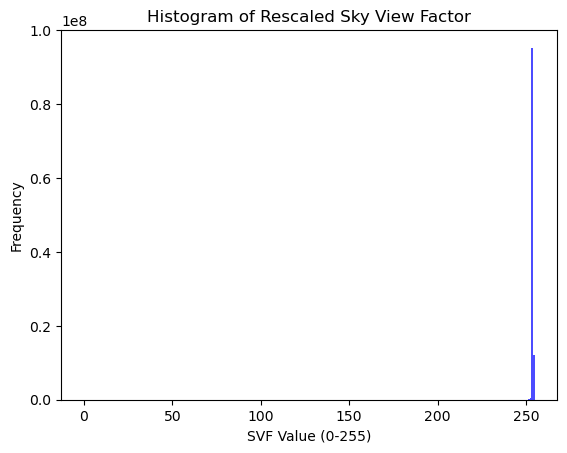

In [9]:
# Load the SVF image
dataset = gdal.Open('E:/Gradu/Resample_DEM_image/DTM/SkyViewFactor_DTM.tif')

# Check if the dataset is loaded successfully
if dataset is None:
    print("Failed to open the file. Please check the file path or format.")
else:
    # Get the first raster band
    band = dataset.GetRasterBand(1)
    svf = band.ReadAsArray()

    # Rescale SVF values from 0-1 to 0-255
    svf_rescaled = svf * 255

    # Ensure values are in 8-bit integer format
    svf_rescaled = svf_rescaled.astype(np.uint8)

    # Define the output file path
    output_file_path = 'E:/Gradu/Resample_DEM_image/DTM/SkyViewFactor_DTM_rescaled.tif'

    # Save the rescaled image
    driver = gdal.GetDriverByName('GTiff')  # Specify the driver for GeoTIFF
    output_dataset = driver.Create(output_file_path, dataset.RasterXSize, dataset.RasterYSize, 1, gdal.GDT_Byte)

    # Check if the output dataset was created successfully
    if output_dataset is None:
        print("Failed to create output file.")
    else:
        output_dataset.GetRasterBand(1).WriteArray(svf_rescaled)
        output_dataset.SetGeoTransform(dataset.GetGeoTransform())  # Copy geotransform from original dataset
        output_dataset.SetProjection(dataset.GetProjection())      # Copy projection from original dataset
        output_dataset.FlushCache()  # Write to disk
        output_dataset = None  # Close the output dataset

        # Print a confirmation message
        print(f"File saved successfully: {output_file_path}")

    # Plot histogram
    plt.hist(svf_rescaled.flatten(), bins=256, range=(0, 255), color='blue', alpha=0.7)
    plt.title('Histogram of Rescaled Sky View Factor')
    plt.xlabel('SVF Value (0-255)')
    plt.ylabel('Frequency')
    plt.show()
